In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle

In [2]:
df = pd.read_csv("C:/Users/DELL/Downloads/Employee-Attrition - Employee-Attrition.csv")

In [50]:
df.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,41,1102,1,2,2,94,3,2,4,5993,...,False,False,False,True,False,False,False,True,False,True
1,49,279,8,1,3,61,2,2,2,5130,...,False,False,True,False,False,False,True,False,True,False
2,37,1373,2,2,4,92,2,1,3,2090,...,False,False,False,False,False,False,False,True,False,True
3,33,1392,3,4,4,56,3,1,3,2909,...,False,False,True,False,False,False,True,False,False,True
4,27,591,2,1,1,40,3,1,2,3468,...,False,False,False,False,False,False,True,False,True,False


In [3]:
# Drop irrelevant columns if needed (like EmployeeNumber, Address)
df.drop(columns=["EmployeeNumber", "Over18", "EmployeeCount", "StandardHours"], inplace=True, errors='ignore')

# Handle categorical variables
df = pd.get_dummies(df)

# Fill or drop missing values
df.fillna(df.median(numeric_only=True), inplace=True)


In [ ]:

df['PerformanceRating'].nunique()

2

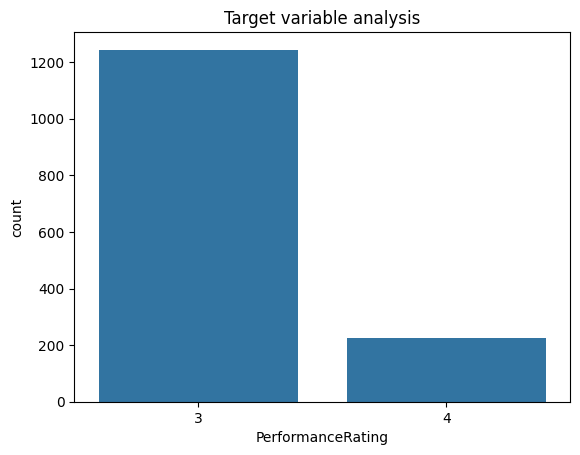

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count of target classes
sns.countplot(x='PerformanceRating', data=df)
plt.title("Target variable analysis")
plt.show()

In [51]:
# Features to use
features = [
    'Education', 'JobInvolvement', 'JobLevel',
    'MonthlyIncome', 'YearsAtCompany', 'YearsInCurrentRole'
]

# # Add any dummy-encoded fields that exist (e.g., 'Department_Sales')
features += [col for col in df.columns if col.startswith("JobRole_") or col.startswith("Department_")]

X = df[features]
y = df['PerformanceRating']  # Target variable


In [52]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [66]:
# After pd.get_dummies and before scaling
expected_cols = X_train.columns.tolist()

In [67]:
# Scaling (optional for tree models, but good practice)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [78]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_scaled, y_train)

In [81]:
# Model training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [82]:
y_pred = model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8344671201814059

Confusion Matrix:
 [[367  12]
 [ 61   1]]

Classification Report:
               precision    recall  f1-score   support

           3       0.86      0.97      0.91       379
           4       0.08      0.02      0.03        62

    accuracy                           0.83       441
   macro avg       0.47      0.49      0.47       441
weighted avg       0.75      0.83      0.79       441



In [71]:
a=y_pred

In [72]:
from sklearn.linear_model import LogisticRegression

In [83]:
lg_model = LogisticRegression(random_state=42)
lg_model.fit(X_train_sm, y_train_sm)

LogisticRegression(random_state=42)

In [74]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7437641723356009

Confusion Matrix:
 [[315  64]
 [ 49  13]]

Classification Report:
               precision    recall  f1-score   support

           3       0.87      0.83      0.85       379
           4       0.17      0.21      0.19        62

    accuracy                           0.74       441
   macro avg       0.52      0.52      0.52       441
weighted avg       0.77      0.74      0.76       441



In [89]:
import pickle
# Save model, scaler, and expected columns
pickle.dump(model, open("model.pkl", "wb"))
pickle.dump(scaler, open("scaler.pkl", "wb"))
pickle.dump(expected_cols, open("columns.pkl", "wb"))


In [90]:
print("model" in globals())


True


In [91]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import pickle

# Load model, scaler, and expected columns
model = pickle.load(open("model.pkl", "rb"))
scaler = pickle.load(open("scaler.pkl", "rb"))
expected_cols = pickle.load(open("columns.pkl", "rb"))

st.title("🎯 Predict Employee Performance Rating")
st.markdown("Fill in the employee details below to predict their performance rating.")

# Manual Inputs
education = st.selectbox("Education Level", [1, 2, 3, 4, 5])
job_involvement = st.slider("Job Involvement (1-4)", 1, 4, 3)
job_level = st.selectbox("Job Level", [1, 2, 3, 4, 5])
monthly_income = st.number_input("Monthly Income", min_value=1000, value=5000, step=1000)
years_at_company = st.slider("Years at Company", 0, 40, 5)
years_in_current_role = st.slider("Years in Current Role", 0, 20, 3)

# Categorical Inputs
job_role = st.selectbox("Job Role", [
    "Sales Executive", "Research Scientist", "Laboratory Technician",
    "Manufacturing Director", "Healthcare Representative", "Manager",
    "Sales Representative", "Research Director", "Human Resources"
])

department = st.selectbox("Department", ["Sales", "Research & Development", "Human Resources"])

# Prediction trigger
if st.button("🔍 Predict"):
    # Initialize all expected features to 0
    input_dict = {col: 0 for col in expected_cols}

    # Assign numeric inputs
    input_dict["Education"] = education
    input_dict["JobInvolvement"] = job_involvement
    input_dict["JobLevel"] = job_level
    input_dict["MonthlyIncome"] = monthly_income
    input_dict["YearsAtCompany"] = years_at_company
    input_dict["YearsInCurrentRole"] = years_in_current_role

    # One-hot encode categorical features
    jobrole_col = f"JobRole_{job_role}"
    dept_col = f"Department_{department}"

    if jobrole_col in input_dict:
        input_dict[jobrole_col] = 1
    else:
        st.warning(f"⚠️ '{job_role}' was not present in training data.")

    if dept_col in input_dict:
        input_dict[dept_col] = 1
    else:
        st.warning(f"⚠️ '{department}' was not present in training data.")

    # Prepare input DataFrame
    input_df = pd.DataFrame([input_dict])[expected_cols]

    # Scale and predict
    input_scaled = scaler.transform(input_df)
    prediction = model.predict(input_scaled)[0]

    st.subheader("🧾 Predicted Performance Rating:")
    st.success(f"🎯 {prediction}")



Overwriting app.py


In [92]:
!streamlit run app.py

^C
